['img', 'msk']
(256, 256, 3)
Num img bands: (1, 2, 3, 4, 5, 6, 7)
(256, 256, 3)
Num img bands: (1, 2, 3, 4, 5, 6, 7)
(256, 256, 3)
Num img bands: (1, 2, 3, 4, 5, 6, 7)
sentinel12_s2_12_msk_10.tif


/vol/tensusers3/nhollain/lakes/lib/python3.10/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


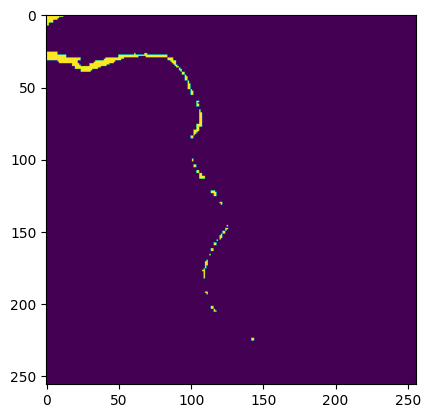

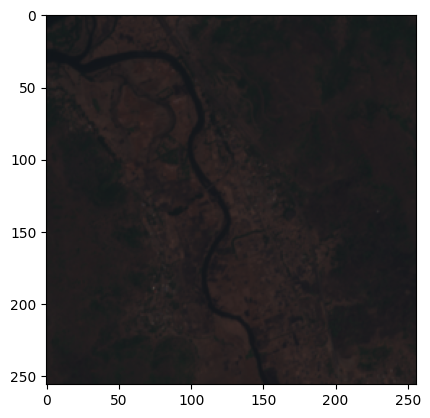

(256, 256, 3)
Num img bands: (1, 2, 3, 4, 5, 6, 7)
(256, 256, 3)
Num img bands: (1, 2, 3, 4, 5, 6, 7)
(256, 256, 3)
Num img bands: (1, 2, 3, 4, 5, 6, 7)
(256, 256, 3)
Num img bands: (1, 2, 3, 4, 5, 6, 7)
(256, 256, 3)
Num img bands: (1, 2, 3, 4, 5, 6, 7)
(256, 256, 3)
Num img bands: (1, 2, 3, 4, 5, 6, 7)
(256, 256, 3)
Num img bands: (1, 2, 3, 4, 5, 6, 7)
sentinel12_s2_12_msk_1005.tif


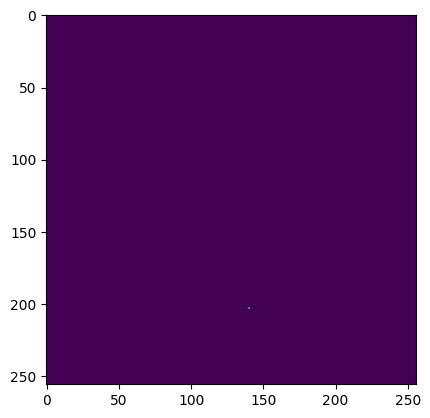

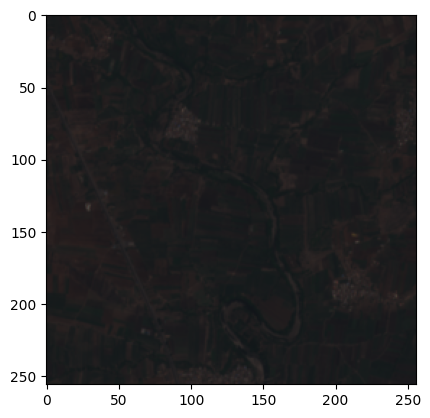

(256, 256, 3)
Num img bands: (1, 2, 3, 4, 5, 6, 7)
(256, 256, 3)
Num img bands: (1, 2, 3, 4, 5, 6, 7)
sentinel12_s2_12_msk_1007.tif


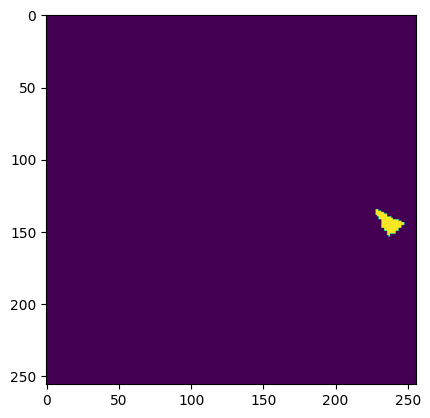

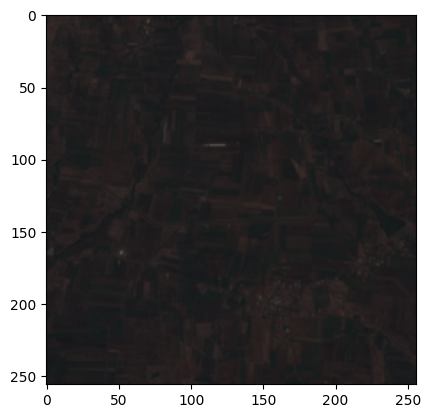

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import rasterio
import json
import random

path = './data_prepped/train/'
print(os.listdir(path))
mask_folder = os.path.join(path, 'msk')
mask_files = sorted(os.listdir(mask_folder))
j = 0
for i in range(20):
    mask_path = os.path.join(mask_folder, mask_files[i])
    if os.path.isdir(mask_path):
        continue
    mask_data = rasterio.open(mask_path)
    
    mask = mask_data.read(1).astype(np.float32)

    img_data = rasterio.open(mask_path.replace('msk', 'img'))
    b, g, r, nir, swir1, swir2, slope  = img_data.read()
    rgb_img = np.stack((r,g,b), axis = -1).astype(np.float32)
    print(rgb_img.shape)
    print('Num img bands:', img_data.indexes)
    if np.sum(mask==1) > 0:
        print(mask_files[i])
        # print(np.where(mask==1))
        plt.imshow(mask)
        plt.show()
        plt.imshow(rgb_img)
        plt.show()
        j += 1
        if j == 3:
            break

### Image bands: "Blue": 0, "Green": 1, "Red": 2, "NIR": 3, "SWIR1": 4, "SWIR2": 5

In [2]:
b, g, r, nir, swir1, swir2, slope  = img_data.read()

In [3]:
andwi = (b+g+r-nir-swir1-swir2) / (b+g+r+nir+swir1+swir2)
ndwi = (g-nir)/(g+nir)
print(andwi)
print(ndwi >= 0.3)

[[-0.26354727 -0.2238246  -0.20787147 ... -0.0862821  -0.08495822
  -0.10117304]
 [-0.27426162 -0.24482073 -0.23468672 ... -0.09207445 -0.08701508
  -0.10072569]
 [-0.2270541  -0.16778658 -0.19219959 ... -0.09433468 -0.11259339
  -0.11817444]
 ...
 [-0.18356232 -0.14488456 -0.20906615 ... -0.18107371 -0.15788074
  -0.15864104]
 [-0.13435008 -0.12999007 -0.20953478 ... -0.18770635 -0.17520706
  -0.1713428 ]
 [-0.14281498 -0.12953067 -0.18709004 ... -0.19503863 -0.17953318
  -0.16692588]]
[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]


In [4]:
import ukis_metrics.seg_metrics as segm
# tpfptnfn = segm.tpfptnfn(y_true, y_pred, None)
# metrics = segm.segmentation_metrics(tpfptnfn)

for threshold in [0.0, 0.1, 0.3, 0.5, 0.7, 0.9, 1.0]:
    tpfptnfn = segm.tpfptnfn(mask == 1, ndwi >= threshold, None)
    metrics = segm.segmentation_metrics(tpfptnfn)
    print(f'Threshold = {threshold}\t{metrics}')

Threshold = 0.0	{'iou': 0.852, 'recall': 1.0, 'precision': 0.852, 'acc': 0.9996, 'F1': 0.9201, 'kappa': 0.9199}
Threshold = 0.1	{'iou': 0.8256, 'recall': 0.8503, 'precision': 0.966, 'acc': 0.9995, 'F1': 0.9045, 'kappa': 0.9042}
Threshold = 0.3	{'iou': 0.0, 'recall': 0.0, 'precision': 0.0, 'acc': 0.9975, 'F1': 0.0, 'kappa': 0.0}
Threshold = 0.5	{'iou': 0.0, 'recall': 0.0, 'precision': 0.0, 'acc': 0.9975, 'F1': 0.0, 'kappa': 0.0}
Threshold = 0.7	{'iou': 0.0, 'recall': 0.0, 'precision': 0.0, 'acc': 0.9975, 'F1': 0.0, 'kappa': 0.0}
Threshold = 0.9	{'iou': 0.0, 'recall': 0.0, 'precision': 0.0, 'acc': 0.9975, 'F1': 0.0, 'kappa': 0.0}
Threshold = 1.0	{'iou': 0.0, 'recall': 0.0, 'precision': 0.0, 'acc': 0.9975, 'F1': 0.0, 'kappa': 0.0}


In [5]:
print(img_data.meta)
print(img_data.bounds)

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 256, 'height': 256, 'count': 7, 'crs': None, 'transform': Affine(1.0, 0.0, 0.0,
       0.0, 1.0, 0.0)}
BoundingBox(left=0.0, bottom=256.0, right=256.0, top=0.0)


In [6]:
# denmark_path = './denmark_data/ortofoto_2020_s10_rendered.tif'
# mask_data = rasterio.open(denmark_path)
# mask_data.crs

In [7]:
with open('denmark_annotations.json', 'r') as f:
    annotations = json.load(f)

In [8]:
os.makedirs('denmark_data', exist_ok = True)
os.makedirs('denmark_data/mask', exist_ok = True)
os.makedirs('denmark_data/img', exist_ok = True)

In [9]:
import rasterio
from rasterio.warp import reproject, calculate_default_transform
import numpy as np

# path = './denmark_data/ortofoto_2020_s10_rendered.tif'
path = './ortodata_2014_res_2_crop.tif'
# Open the tif file 
dataset = rasterio.open(path)
print(dataset.shape)
print(dataset.crs)

(135000, 85000)
EPSG:25832


In [10]:
left, bottom, right, top = np.array(dataset.bounds).astype(int)
print(left, bottom, right, top)

440000 6070000 610000 6340000


In [11]:
%%time
data  = dataset.read()
print(len(data))
r, g, b, unknown = data
r = r.astype(np.float16)
g = g.astype(np.float16)
b = b.astype(np.float16)
# print(unknown.shape, np.unique(unknown))

4
CPU times: user 2min 39s, sys: 1min 5s, total: 3min 44s
Wall time: 3min 44s


  0%|                                                                                        | 0/148995 [00:00<?, ?it/s]

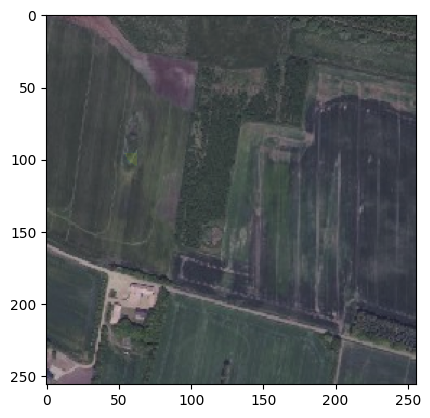

  0%|                                                                              | 1/148995 [00:00<7:31:08,  5.50it/s]

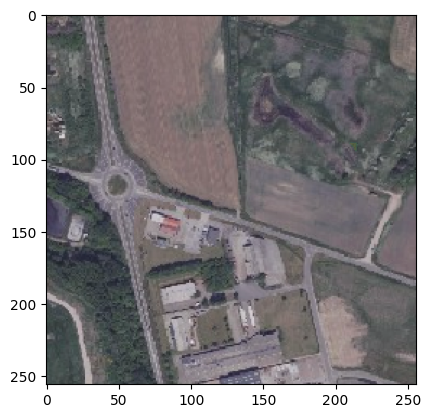

  0%|                                                                              | 4/148995 [00:00<3:34:33, 11.57it/s]

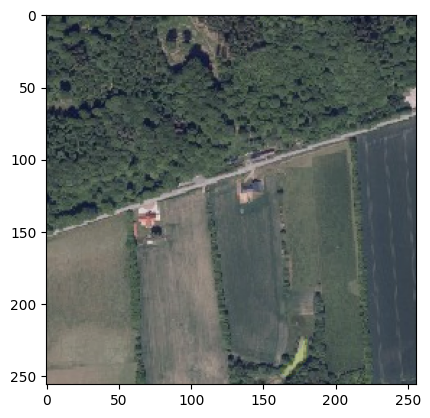

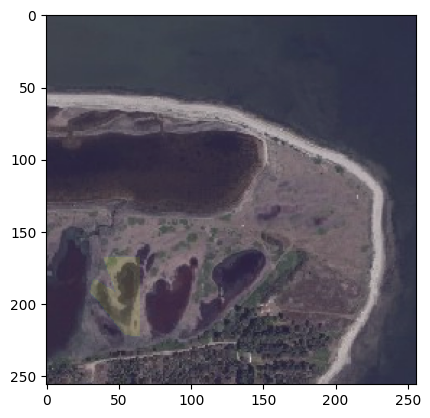

  0%|                                                                              | 6/148995 [00:00<5:17:26,  7.82it/s]

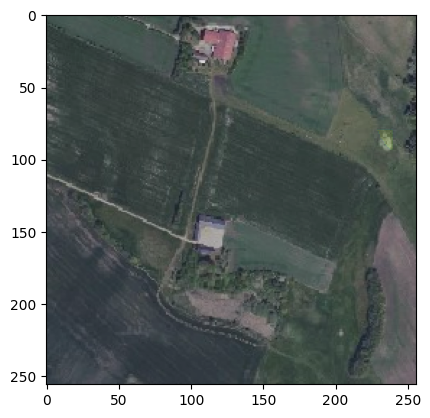

  0%|                                                                              | 7/148995 [00:00<5:25:57,  7.62it/s]


In [42]:
from tqdm import tqdm
pad = 40

i = 0
for annotation in tqdm(annotations):
    # Load the annotated mask of the lake
    lake_mask = np.array(annotation['mask'])
    
    # Get the coordinates of the lake in the form [(x1, y1), (x2, y2), ...]
    # print(annotation['coordinates'])
    lake_coords = np.array(annotation['coordinates']).reshape(-1, 2)#.astype(int)
    
    # Split x and y coordinates
    x, y = lake_coords[:, 0], lake_coords[:, 1] #np.round(lake_coords[:, 0]), np.round(lake_coords[:, 1])
    
    # Get the minimum and maximum bounds of the lake
    x_min, x_max = np.min(x), np.max(x)
    y_min, y_max = np.min(y), np.max(y)

    # The data consist of an array which has some defined bounds
    # We now retrieve the index of our x and ys in relation to those bounds
    x_min_idx, y_min_idx = dataset.index(x_min, y_min)
    x_max_idx, y_max_idx = dataset.index(x_max, y_max)

    # Compute width and height
    w = abs(x_max_idx - x_min_idx)
    h = abs(y_max_idx - y_min_idx)

    # Define target size for images, and find out how far off we are from that
    target_w, target_h = 256, 256
    delta_w, delta_h = target_w - w, target_h - h
    if delta_w < 0 or delta_h < 0: # If the image is already bigger than the target, skip it
        continue

    # Add random padding to the image to obtain the target size
    left_pad = random.randint(1, delta_w)
    right_pad = delta_w - left_pad
    bottom_pad = random.randint(1, delta_h)
    top_pad = delta_h - bottom_pad
    # left_pad, top_pad, bottom_pad, right_pad = [2] * 4
    
    # We crop to the location of the lake, plus some padding around it
    r_crop = r[x_max_idx-left_pad:x_min_idx+right_pad, y_min_idx-bottom_pad:y_max_idx+top_pad]
    g_crop = g[x_max_idx-left_pad:x_min_idx+right_pad, y_min_idx-bottom_pad:y_max_idx+top_pad]
    b_crop = b[x_max_idx-left_pad:x_min_idx+right_pad, y_min_idx-bottom_pad:y_max_idx+top_pad]
    rgb_img = np.stack((r_crop,g_crop,b_crop), axis = -1).astype(np.float16)

    # Also pad the dimensions of the mask to include padding
    old_shape = lake_mask.shape
    lake_mask = np.pad(lake_mask, ((left_pad, right_pad), (bottom_pad, top_pad)), 'constant', constant_values=0)

    # Display the mask overlayed on the cropped image
    try:
        crop_img = rgb_img.astype(int) 
        plt.imshow(crop_img)
        plt.imshow(lake_mask, alpha = 0.1)
        plt.show()
        # print('r shape before pad', r[x_max_idx:x_min_idx, y_min_idx:y_max_idx].shape)
        # print('before padding mask (shape)', old_shape)
        # print(crop_img.shape)
        # print(lake_mask.shape)
        # print('pad', left_pad, right_pad, bottom_pad, top_pad, left_pad+right_pad, bottom_pad+top_pad)
    except:
        continue
    i += 1
    if i == 5:
        break

In [12]:
lake_coords = [[[[501332.248, 6224773.935], [501334.244, 6224779.934], [501334.244, 6224784.933], [501333.246, 6224790.932], 
                 [501327.243, 6224789.932], [501317.249, 6224783.933], [501316.243, 6224780.934], [501319.244, 6224774.935], 
                 [501324.25, 6224771.936], [501329.247, 6224770.936], [501332.248, 6224773.935]]]]
lake_coords = (np.array(lake_coords)).reshape(-1, 2)
x, y = np.round(lake_coords[:, 0]).astype(int), np.round(lake_coords[:, 1]).astype(int)
x_min, x_max = np.min(x), np.max(x)
y_min, y_max = np.min(y), np.max(y)
(x_min, y_min), (x_max, y_max)

(501316, 501334, 6224771, 6224791)

In [15]:
x_min_idx, y_min_idx = dataset.index(x_min, y_min)
x_max_idx, y_max_idx = dataset.index(x_max, y_max)
(x_min_idx, y_min_idx), (x_max_idx, y_max_idx)

((57614, 30658), (57604, 30667))

In [16]:
%%time
# rgb_img = np.stack((r,g,b), axis = -1).astype(np.float16)
# rgb_img.shape

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 5.72 µs


In [17]:
pad = 40
r_crop = r[x_max_idx-pad:x_min_idx+pad, y_min_idx-pad:y_max_idx+pad]
g_crop = g[x_max_idx-pad:x_min_idx+pad, y_min_idx-pad:y_max_idx+pad]
b_crop = b[x_max_idx-pad:x_min_idx+pad, y_min_idx-pad:y_max_idx+pad]
rgb_img = np.stack((r_crop,g_crop,b_crop), axis = -1).astype(np.float16)

In [19]:
left, bottom, right, top = np.array(mask_data.bounds).astype(int)
print(left, bottom, right, top)

892423 7237562 1695952 7923450


In [30]:
img_mask = np.array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
       [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
       [0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
       [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
       [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
       [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
       [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
       [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
       [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0],
       [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0],
       [0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0],
       [0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0]])
print(img_mask.shape)
img_mask = np.pad(img_mask, ((pad, pad), (pad, pad)), 'constant', constant_values=0)
print(img_mask.shape)
img_mask

(18, 20)
(98, 100)


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

(90, 89, 3)


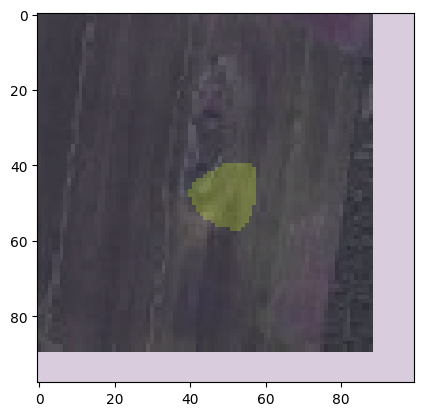

In [31]:
crop_img = rgb_img.astype(int) #rgb_img[x_max_idx-pad:x_min_idx+pad, y_min_idx-pad:y_max_idx+pad, :].astype(int)
print(crop_img.shape)
plt.imshow(crop_img)
plt.imshow(img_mask, alpha = 0.2)
# print(crop_img)

In [12]:
left-x_min, left-x_max, top-y_min, top-y_max

(-65217, -65235, 197700, 197680)

In [15]:
reprojected_dataset.index(x_min, y_min)

(35408, 11680)

(0, 0, 3)


ValueError: zero-size array to reduction operation minimum which has no identity

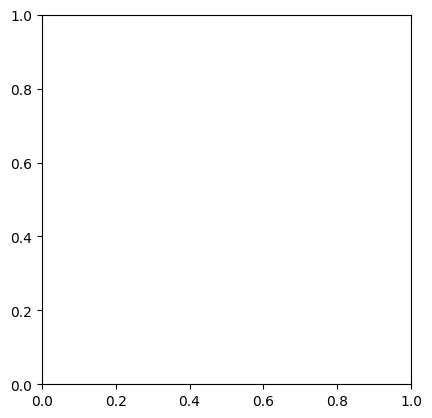

In [26]:
crop_img = rgb_img[int((left-x_min)/10):int((left-x_max)/10), int((top-y_min)/10):int((top-y_max)/10), :].astype(int)
print(crop_img.shape)
plt.imshow(crop_img)
print(crop_img)

In [ ]:
crop_img

In [ ]:
mask_data.index(501334, 6224771)

In [ ]:
mask_data.crs